## Imports and config

In [4]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import partridge as ptg
import datetime
import os
import matplotlib.pyplot as plt

#import gtfs_utils as gu
#import gtfstk


In [6]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Read files

In [7]:
import glob
rs = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_ffill\\2018-*_route_stats.pkl.gz')])
      .assign(date = lambda x: pd.to_datetime(x.date))
      .assign(dayofweek = lambda x: x['date'].dt.strftime('%A')))

In [8]:
rs.shape

(1368384, 37)

In [9]:
rs.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10002
route_short_name,1,4,91,91,92
agency_id,25,25,14,14,14
agency_name,אפיקים,אפיקים,נתיב אקספרס,נתיב אקספרס,נתיב אקספרס
route_long_name,תחנת רכבת יבנה מערב-יבנה<->תחנת רכבת מזרח-יבנה-1#,תחנת רכבת מזרח-יבנה<->תחנת רכבת יבנה מערב-יבנה-2#,קופת חולים/הנשיא-צפת<->דרך חטיבת יפתח-צפת-11,האר''י/ישראל ב''ק-צפת<->שפרינצק/קרן היסוד-צפת-2#,געתון/מירון-כפר ורדים<->בית ספר כפר ורדים-כפר ...
route_type,3,3,3,3,3
num_trips,26,35,1,5,1
num_trip_starts,26,35,1,5,1
num_trip_ends,26,35,1,5,1
is_loop,0,0,0,0,0


In [10]:
total_trips = (rs.set_index('date').resample('D').num_trips.sum().reset_index().groupby(pd.Grouper(key='date', freq='W-SUN')).agg(['min', 'mean', 'max', 'sum']).reset_index())
total_trips.columns = ['date', 'min', 'mean', 'max', 'sum']
total_trips.head()

,date,min,mean,max,sum
0,2018-01-07,17616,72737.857143,89915,509165
1,2018-01-14,17771,73073.285714,90134,511513
2,2018-01-21,17707,73150.857143,90259,512056
3,2018-01-28,17805,73299.428571,90371,513096
4,2018-02-04,17355,73423.142857,90541,513962


In [11]:
weekday_total = (rs.set_index('date').resample('D').num_trips.sum().reset_index()
                 .assign(dayofweek = lambda x: x.date.dt.strftime('%A'))
                 .set_index('date'))

weekday_total =  (weekday_total[~weekday_total.dayofweek.isin(['Friday', 'Saturday'])]
                  .groupby(pd.Grouper(level=0, freq='W-SUN'))
                  .agg(['min', 'mean', 'max', 'idxmax', 'idxmin'])
                  .reset_index())
weekday_total.columns = ['date', 'weekday_min', 'weekday_mean', 'weekday_max', 'max_weekday', 'min_weekday']
alltots = total_trips.merge(weekday_total)

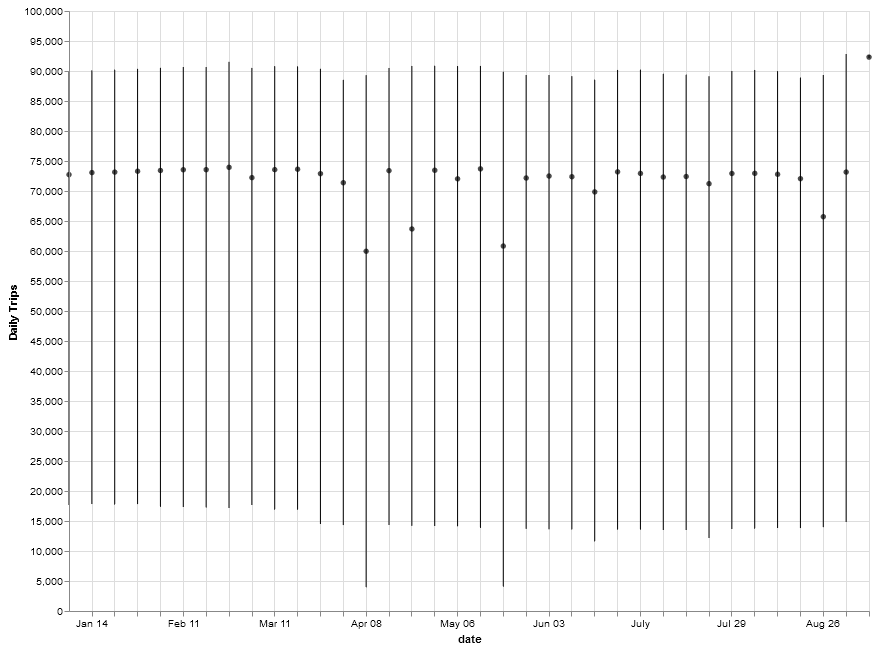

In [12]:
points = alt.Chart(total_trips).mark_point(filled=True).encode(
    alt.Y(
        'mean',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Daily Trips')
    ),
    x='date:T',
    color=alt.value('black')
)

error_bars = alt.Chart(total_trips).mark_rule().encode(
    x='date:T',
    y='min',
    y2='max'
)

(points + error_bars).properties(height=600, width=800)

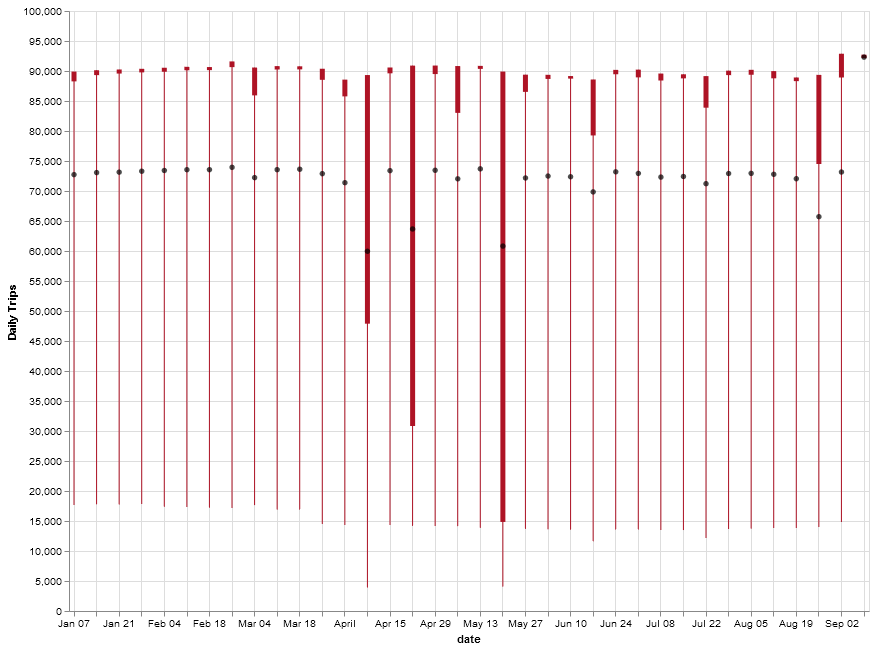

In [13]:
weekday_min_color = alt.condition("datum.weekday_min != datum.min",
                                 alt.value("#06982d"),
                                 alt.value("#ae1325"))

rule = alt.Chart(alltots).mark_rule().encode(
    alt.X(
        'date:T',
    ),
    alt.Y(
        'min',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Daily Trips')
    ),
    alt.Y2('max'),
    color=alt.value("#ae1325"),
    tooltip=[alt.Tooltip('date:T', format='%A, %B %e'),'min', 'max', 'mean']
)

bar = alt.Chart(alltots).mark_bar().encode(
    x='date:T',
    y='weekday_min',
    y2='weekday_max',
    color=alt.value("#ae1325"),
    tooltip=[alt.Tooltip('date:T', format='%A, %B %e'), 'weekday_mean', alt.Tooltip('min_weekday:T', format='%A, %B %e'), alt.Tooltip('max_weekday:T', format='%A, %B %e')]
)

(rule + bar + points).properties(height=600, width=800)

In [14]:
wd_avg = rs.groupby('dayofweek').num_trips.sum() / rs.groupby('dayofweek').date.nunique() 
wd_avg

dayofweek
Friday       45874.200000
Monday       89393.833333
Saturday     14622.400000
Sunday       87339.171429
Thursday     86450.222222
Tuesday      89185.277778
Wednesday    88801.166667
dtype: float64

In [16]:
eid_routes = rs[(rs.date>'2018-08-19') & (rs.date<'2018-08-25')]
week_before_routes = rs[(rs.date<='2018-08-17') & (rs.date>'2018-08-12')]

In [17]:
id_num_trips = eid_routes.groupby('dayofweek').num_trips.sum()
id_num_trips 

dayofweek
Friday       44205
Monday       87241
Thursday     75521
Tuesday      74508
Wednesday    75273
Name: num_trips, dtype: int64

In [18]:
week_before = week_before_routes.groupby('dayofweek').num_trips.sum()

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


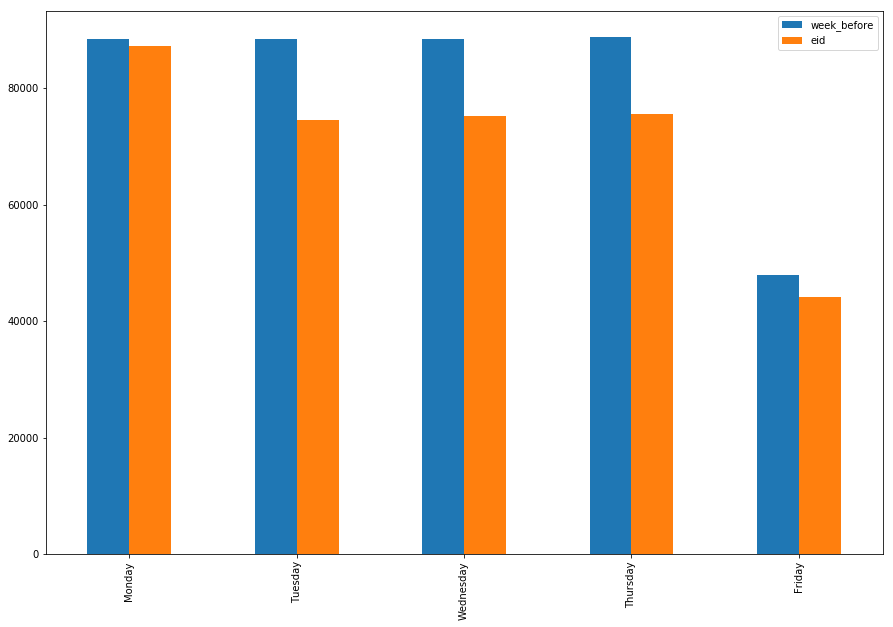

In [22]:
comp = pd.concat([wd_avg, week_before, id_num_trips], axis=1, keys = ['avg', 'week_before', 'eid']).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
comp[['week_before', 'eid']].plot(figsize=(15,10), kind='bar')

In [23]:
sums = comp.loc[['Tuesday', 'Wednesday', 'Thursday']].sum()
sums['eid'] / sums['week_before']

0.8485663386175233

In [24]:
comp['pct_change'] = (100*(1-np.round((comp.week_before/comp.eid), 2))).astype(int)
comp

,avg,week_before,eid,pct_change
Monday,89393.833333,88333.0,87241.0,-1
Tuesday,89185.277778,88317.0,74508.0,-18
Wednesday,88801.166667,88378.0,75273.0,-16
Thursday,86450.222222,88814.0,75521.0,-17
Friday,45874.200000,47832.0,44205.0,-8


In [25]:
id_num_trips_zone = eid_routes.groupby(['dayofweek', 'start_zone']).num_trips.sum()
week_before_zone = week_before_routes.groupby(['dayofweek', 'start_zone']).num_trips.sum()

comp_zone = (pd.concat([week_before_zone, id_num_trips_zone], axis=1, keys = ['week_before', 'eid'])
             #.stack()
             .reset_index()
             #.rename(columns={'level_2': 'week', 0: 'num_trips'})
            )


comp_zone['pct_change'] = (-100*(1-np.round((comp_zone.eid/comp_zone.week_before), 2))).astype(int)

sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
comp_zone.dayofweek = comp_zone.dayofweek.astype("category")
comp_zone.dayofweek.cat.set_categories(sorter, inplace=True)
comp_zone=comp_zone.sort_values('dayofweek')
comp_zone

,dayofweek,start_zone,week_before,eid,pct_change
58,Monday,חריש ואדי ערה,1859,1838,-1
53,Monday,דרום הר חברון,49,49,0
52,Monday,גליל עליון ורמת הגולן,1363,1367,0
51,Monday,גוש שילה ובקעה,46,46,0
50,Monday,גוש עציון,250,250,0
49,Monday,גוש דן,23012,22427,-3
48,Monday,בקעת ים המלח,11,11,0
47,Monday,בנימין,101,101,0
46,Monday,בית שאן,346,346,0
45,Monday,באר שבע,4042,4044,0


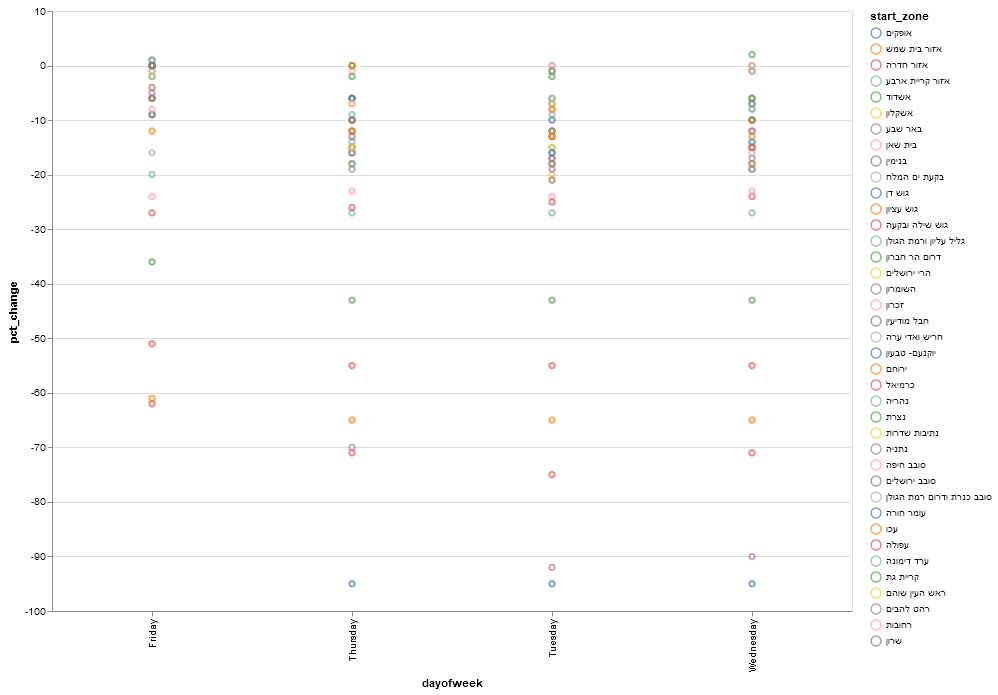

In [26]:
alt.Chart(comp_zone[~comp_zone.dayofweek.isin(('Saturday', 'Sunday', 'Monday'))]).mark_point().encode(
    x = alt.X('dayofweek:N', ),
    y = 'pct_change',
    color = 'start_zone:N',
    tooltip = 'start_zone',
).properties(height=600, width=800)

In [27]:
comp_zone.sort_values('pct_change').to_csv('data/eid_comp_zone.csv')

In [28]:
id_num_trips_zone_inside = eid_routes[eid_routes.start_zone==eid_routes.end_zone].groupby(['dayofweek', 'start_zone', 'agency_name']).num_trips.sum()
week_before_zone_inside = week_before_routes[week_before_routes.start_zone==week_before_routes.end_zone].groupby(['dayofweek', 'start_zone', 'agency_name']).num_trips.sum()

comp_zone_inside = (pd.concat([week_before_zone_inside, id_num_trips_zone_inside], axis=1, keys = ['week_before', 'eid'])
             #.stack()
             .reset_index()
             #.rename(columns={'level_2': 'week', 0: 'num_trips'})
            )


comp_zone_inside['pct_change'] = (-100*(1-np.round((comp_zone_inside.eid/comp_zone_inside.week_before), 2)))#.astype(int)

sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
comp_zone_inside.dayofweek = comp_zone_inside.dayofweek.astype("category")
comp_zone_inside.dayofweek.cat.set_categories(sorter, inplace=True)
comp_zone_inside=comp_zone_inside.sort_values('dayofweek')
comp_zone_inside.sort_values('pct_change')

,dayofweek,start_zone,agency_name,week_before,eid,pct_change
292,Tuesday,רהט להבים,גלים,555,5.0,-99.0
367,Wednesday,רהט להבים,גלים,555,5.0,-99.0
30,Friday,כרמיאל,נסיעות ותיירות,204,8.0,-96.0
226,Tuesday,אזור חדרה,קווים,529,39.0,-93.0
255,Tuesday,כרמיאל,נסיעות ותיירות,416,32.0,-92.0
330,Wednesday,כרמיאל,נסיעות ותיירות,416,32.0,-92.0
180,Thursday,כרמיאל,נסיעות ותיירות,416,32.0,-92.0
333,Wednesday,נצרת,גי.בי.טורס,122,12.0,-90.0
183,Thursday,נצרת,גי.בי.טורס,122,12.0,-90.0
258,Tuesday,נצרת,גי.בי.טורס,122,12.0,-90.0


In [29]:
comp_zone_inside.sort_values('pct_change').to_csv('data/eid_comp_zone_inside_agency.csv')

In [30]:
CLUSTER_TO_LINE = 'data/archive/2018-08-22/ClusterToLine.zip'

def get_cluster_to_line_df(path):
    cols = ['agency_name', 'route_id', 'route_short_name', 
            'cluster_name', 'from_date', 'to_date', 'cluster_id', 
            'route_type', 'route_type_desc', 'cluster_sub_desc', 'EXTRA']
    ctl = (pd.read_csv(path, encoding='windows-1255', 
                      skiprows=[0], header=None, names = cols)
           .drop(columns=['EXTRA']))
    return ctl

ctl = get_cluster_to_line_df(CLUSTER_TO_LINE)
ctl.route_id = ctl.route_id.astype(str)
ctl.shape

(3011, 10)

In [31]:
rs.groupby('date').size().head()

date
2018-01-01    6401
2018-01-02    6447
2018-01-03    6457
2018-01-04    6537
2018-01-05    5211
dtype: int64

In [325]:
ctl.head()

,agency_name,route_id,route_short_name,cluster_name,from_date,to_date,cluster_id,route_type,route_type_desc,cluster_sub_desc
0,אגד,10003,3,חיפה עירוני,01/01/2012,01/01/2200,81,1,עירוני,NaN
1,אגד,10005,5,חיפה עירוני,01/01/2012,01/01/2200,81,1,עירוני,NaN
2,אגד,10006,6,חיפה עירוני,01/01/2012,01/01/2200,81,1,עירוני,NaN
3,אגד,10007,7,חיפה עירוני,01/01/2012,01/01/2200,81,1,עירוני,NaN
4,אגד,10008,8,חיפה עירוני,01/01/2012,01/01/2200,81,1,עירוני,NaN


In [327]:
rs[rs.date=='2018-08-22']

,route_id,route_short_name,agency_id,agency_name,route_long_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,...,start_stop_lon,end_stop_lat,end_stop_lon,num_stops,start_zone,end_zone,num_zones,num_zones_missing,date,dayofweek
0,1,1,25,אפיקים,ת. רכבת יבנה מערב-יבנה<->ת. רכבת יבנה מזרח-יבנ...,3,26,26,26,0,...,34.731191,31.862123,34.744215,19,רחובות,רחובות,1,0,2018-08-22,Wednesday
1,10,4,25,אפיקים,ת. רכבת יבנה מזרח-יבנה<->ת. רכבת יבנה מערב-יבנ...,3,35,35,35,0,...,34.744215,31.890700,34.731191,25,רחובות,רחובות,1,0,2018-08-22,Wednesday
2,10001,91,14,נתיב אקספרס,האר''י/ישראל ב''ק-צפת<->שפרינצק/קרן היסוד-צפת-2#,3,4,4,4,0,...,35.493324,32.958485,35.494245,26,גליל עליון ורמת הגולן,גליל עליון ורמת הגולן,1,0,2018-08-22,Wednesday
3,10007,422,25,אפיקים,א.תעשייה בני ברק-בני ברק<->המ''ג/ירמיהו-ירושלי...,3,39,39,37,0,...,34.827959,31.790641,35.199964,32,גוש דן,סובב ירושלים,3,0,2018-08-22,Wednesday
4,10014,422,25,אפיקים,המ''ג/ירמיהו-ירושלים<->א.תעשייה בני ברק-רמת גן-20,3,41,41,38,0,...,35.200056,32.102350,34.827827,31,סובב ירושלים,גוש דן,3,0,2018-08-22,Wednesday
5,10020,425,25,אפיקים,החרש/עמל-פתח תקווה<->ת. מרכזית י-ם/הורדה-ירושל...,3,10,10,10,0,...,34.852768,31.789115,35.202598,48,גוש דן,סובב ירושלים,5,0,2018-08-22,Wednesday
6,10021,425,25,אפיקים,ת. מרכזית ירושלים קומה 3/רציפים-ירושלים<->עמל/...,3,8,8,8,0,...,35.203715,32.095074,34.854151,40,סובב ירושלים,גוש דן,5,0,2018-08-22,Wednesday
7,10022,427,25,אפיקים,א.תעשייה בני ברק-בני ברק<->ת. מרכזית י-ם/הורדה...,3,1,1,1,0,...,34.827959,31.789115,35.202598,23,גוש דן,סובב ירושלים,3,0,2018-08-22,Wednesday
8,10023,427,25,אפיקים,ת. מרכזית ירושלים קומה 3/רציפים-ירושלים<->א.תע...,3,1,1,1,0,...,35.203715,32.102350,34.827827,24,סובב ירושלים,גוש דן,3,0,2018-08-22,Wednesday
9,1003,76,18,קווים,ת. מרכזית פ''ת/רציפים עירוני-פתח תקווה<->מסוף ...,3,44,44,43,0,...,34.886530,32.021122,34.863511,42,גוש דן,גוש דן,1,0,2018-08-22,Wednesday


In [223]:
crs = rs.merge(ctl[['route_id', 'cluster_name', 'route_type_desc']], on='route_id', how='left')
eid_routes = crs[crs.date>'2018-08-19']
week_before_routes = crs[(crs.date<='2018-08-19') & (crs.date>'2018-08-12')]

In [224]:
id_num_trips_cluster = eid_routes.groupby(['dayofweek', 'cluster_name', 'route_type_desc']).num_trips.sum()
week_before_cluster = week_before_routes.groupby(['dayofweek', 'cluster_name', 'route_type_desc']).num_trips.sum()

comp_cluster = (pd.concat([week_before_cluster, id_num_trips_cluster], axis=1, keys = ['week_before', 'eid'])
             #.stack()
             .reset_index()
             .fillna(0)
             #.rename(columns={'level_2': 'week', 0: 'num_trips'})
            )
comp_cluster

,dayofweek,cluster_name,route_type_desc,week_before,eid
0,Friday,אבו תור,עירוני,8.0,8.0
1,Friday,אגד תעבורה-קווי חרדים,בינעירוני,55.0,55.0
2,Friday,אונו-אלעד,אזורי,12.0,12.0
3,Friday,אונו-אלעד,בינעירוני,146.0,126.0
4,Friday,אונו-אלעד,עירוני,66.0,48.0
5,Friday,אילת עירוני ובינעירוני,בינעירוני,179.0,160.0
6,Friday,אילת עירוני ובינעירוני,עירוני,20.0,20.0
7,Friday,אשדוד עירוני,עירוני,24.0,18.0
8,Friday,אשדוד-אשקלון-ירושלים,בינעירוני,65.0,65.0
9,Friday,"אשדוד-יבנה-ת""א",בינעירוני,128.0,128.0


In [225]:
comp_cluster['pct_change'] = (-100*(1-np.round((comp_cluster.eid.divide(comp_cluster.week_before, fill_value=0)), 3)))#.replace(np.inf, np.nan).dropna().astype(int)

sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
comp_cluster.dayofweek = comp_cluster.dayofweek.astype("category")
comp_cluster.dayofweek.cat.set_categories(sorter, inplace=True)
comp_cluster=comp_cluster.sort_values('dayofweek')
comp_cluster

,dayofweek,cluster_name,route_type_desc,week_before,eid,pct_change
100,Monday,אונו-אלעד,אזורי,13.0,13.0,-0.0
127,Monday,השרון,בינעירוני,118.0,118.0,-0.0
128,Monday,השרון,עירוני,34.0,32.0,-5.9
129,Monday,חדרה פרברי,עירוני,89.0,89.0,-0.0
130,Monday,חדרה-נתניה,אזורי,12.0,12.0,-0.0
131,Monday,חדרה-נתניה,בינעירוני,316.0,316.0,-0.0
132,Monday,חדרה-נתניה,עירוני,8.0,6.0,-25.0
133,Monday,חולון עירוני ומטרופוליני+תחרות חולון,בינעירוני,92.0,92.0,-0.0
134,Monday,חולון עירוני ומטרופוליני+תחרות חולון,עירוני,113.0,113.0,-0.0
135,Monday,חיפה עירוני,בינעירוני,4.0,4.0,-0.0


In [226]:
comp_cluster[comp_cluster.week_before>0].sort_values('pct_change').to_csv('data/eid_comp_cluster.csv')

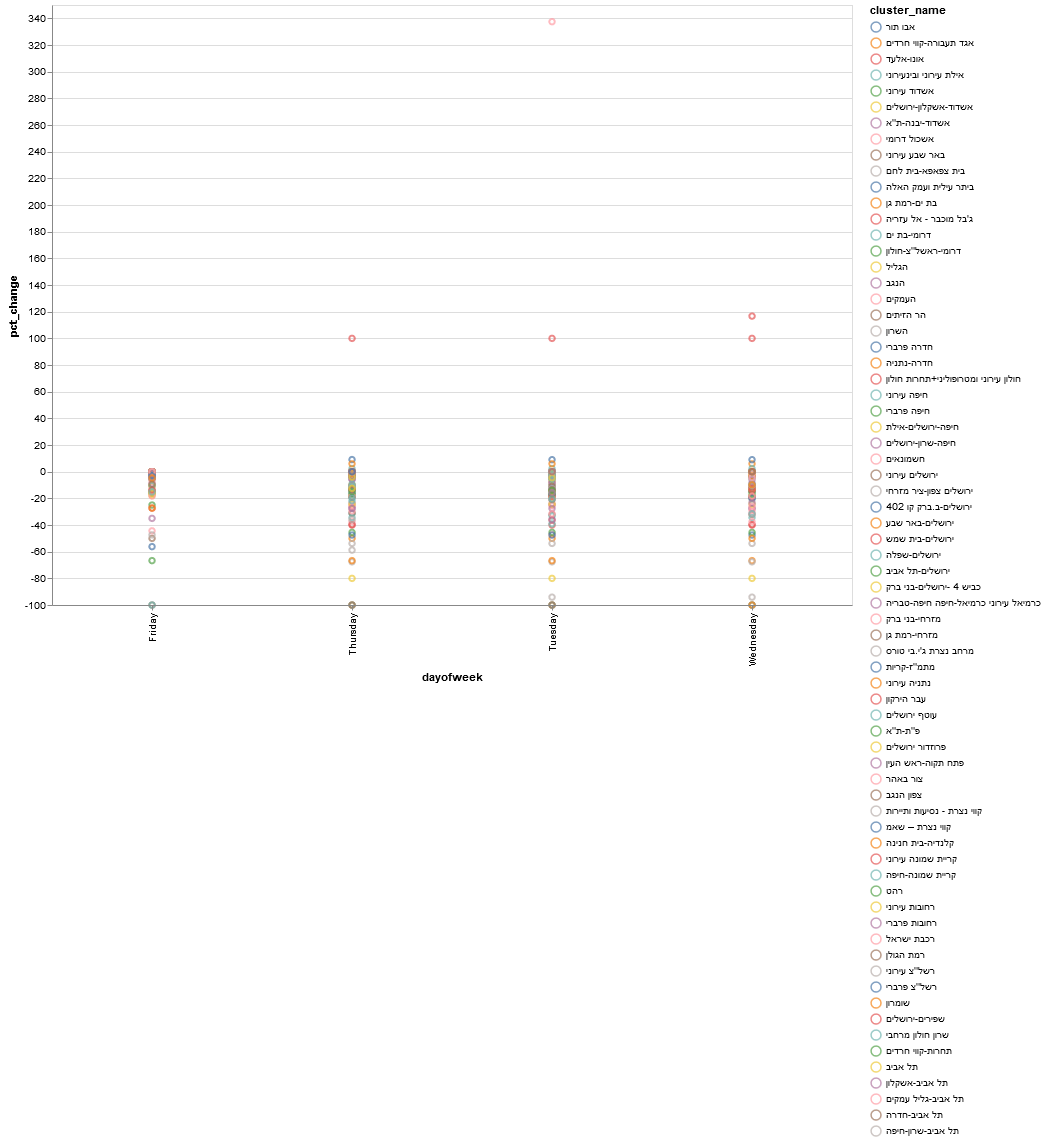

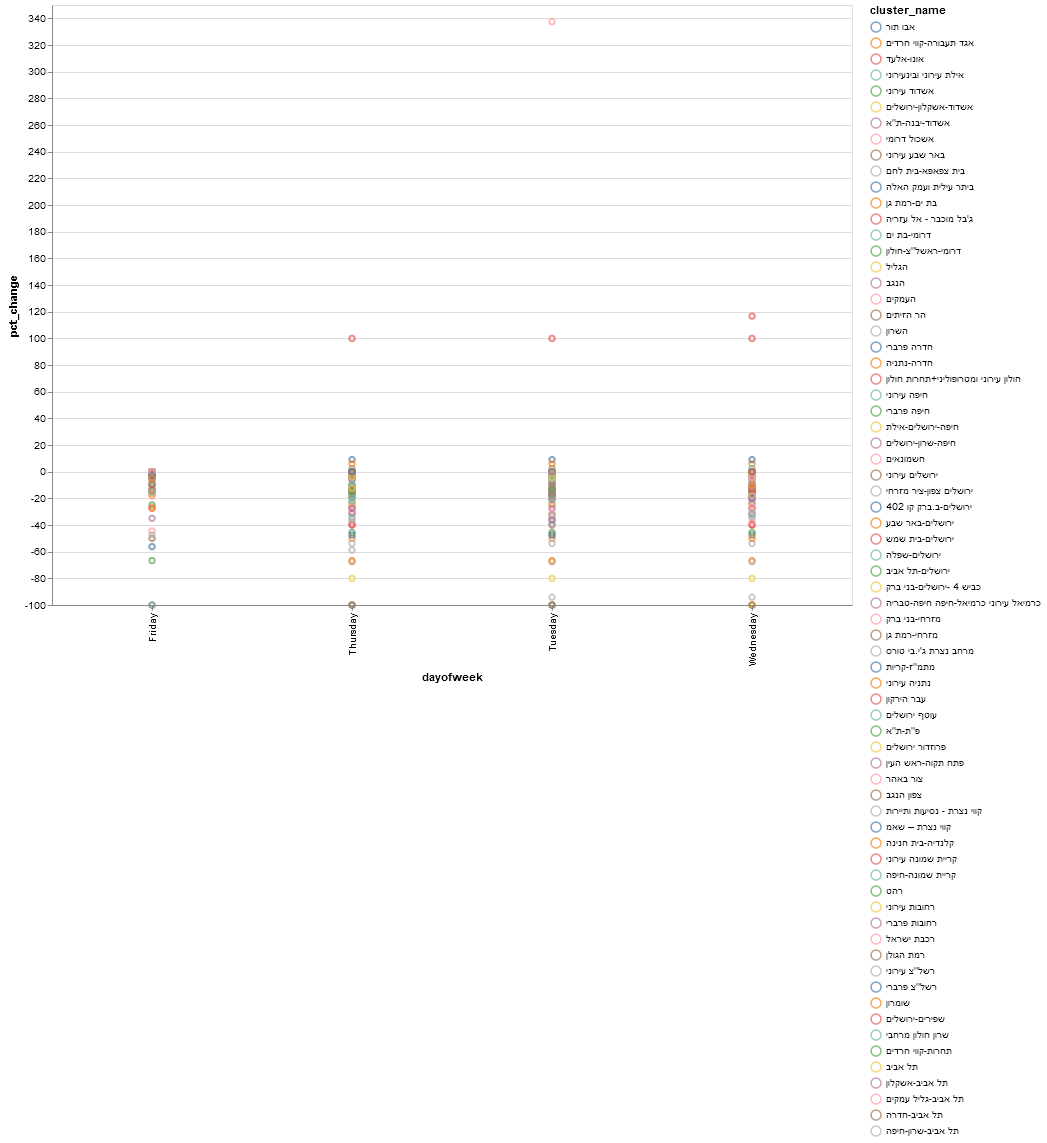

In [227]:
alt.Chart(comp_cluster[~comp_cluster.dayofweek.isin(('Saturday', 'Sunday', 'Monday'))]).mark_point().encode(
    x = alt.X('dayofweek:N', ),
    y = 'pct_change',
    color = 'cluster_name:N',
    tooltip = 'cluster_name',
).properties(height=600, width=800)

In [59]:
routes_to_check = ['149','271', '300', '301', '350', '361', '369', '402',
                  '417', '433', '437', '470', '480', '500', '826',
                  '836', '845', '947']
rids_149 = ['7716', '7718']#, '7719', '7720']
rids = ['4440', '4444', '4446', '4443', '16723',
        '7393', '7395', '14180', '14181', '14183', '14184', '14185', 
        #'13690', '7396', '7398', '7400', '7402', 
        '6588', '6601', '16314', '17845', '13666', '19577', '17846',
        '4474', '4475',
        '8151', '8153', '8162', '8164', '8165',
        '17143', '6642', '16241', '16242', '16245', '6635', '16240', '16244', '6646', '6649',
        '6656', '6660', '6661', '16415',
        '6952', '6954',
        '6966', '6967', '6969',
        '7005', '7007', '7008', '7012',  '7013', '7014', '7015', '7016',
        '10958', '7020', '7022', '7023', '7024', '7026', '7027', '7028', '7030', '7033', '7034', '15337',
        '19671', '19672',
        '15123', '19731', '7072', '7083', '7081', '7079',
        '13347', '7111', '7112',
        '7159', '7161',
        '19740', '19741', '7220', '7221', '7224', '7226', '13136', '7225'
        
       ]
(week_before_routes[week_before_routes.route_short_name==routes_to_check[0]]
 .drop_duplicates(subset=['route_id', 'route_short_name', 'route_long_name'])
 #.route_id.tolist()
)

,route_id,route_short_name,agency_id,agency_name,route_long_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,...,start_stop_lon,end_stop_lat,end_stop_lon,num_stops,start_zone,end_zone,num_zones,num_zones_missing,date,dayofweek
1387,14617,149,4,אגד תעבורה,תחנת רקל''ה פסגת זאב מרכז/משה דיין-ירושלים<->מ...,3,9,9,9,0,...,35.237533,31.831292,35.293475,10,סובב ירושלים,סובב ירושלים,1,0,2018-08-13,Monday
1388,14618,149,4,אגד תעבורה,מעלה בנימין/כנפי רוח-עלמון<->תחנת רקל''ה פסגת ...,3,9,9,9,0,...,35.291775,31.824388,35.237595,11,סובב ירושלים,סובב ירושלים,1,0,2018-08-13,Monday
3357,21026,149,14,נתיב אקספרס,מזכירות-כלנית<->ת. רכבת כרמיאל/הורדה-כרמיאל-1#,3,3,3,3,0,...,35.455105,32.923819,35.297919,40,סובב כנרת ודרום רמת הגולן,כרמיאל,2,0,2018-08-13,Monday
3358,21027,149,14,נתיב אקספרס,ת. רכבת כרמיאל/רציפים-כרמיאל<->מזכירות-כלנית-2#,3,3,3,3,0,...,35.298351,32.874014,35.455105,40,כרמיאל,סובב כנרת ודרום רמת הגולן,2,0,2018-08-13,Monday
4810,7716,149,15,מטרופולין,איזור התעשיה כפר סבא-כפר סבא<->מסוף כרמלית/הכר...,3,74,74,72,0,...,34.926906,32.066363,34.766098,43,שרון,גוש דן,2,0,2018-08-13,Monday
4811,7718,149,15,מטרופולין,צומת גלילות - בסיס צבאי-רמת השרון<->מסוף כרמלי...,3,1,1,1,0,...,34.816839,32.066363,34.766098,23,שרון,גוש דן,2,0,2018-08-13,Monday
4812,7719,149,15,מטרופולין,מסוף כרמלית-תל אביב יפו<->איזור התעשיה כפר סבא...,3,65,65,63,0,...,34.764834,32.178298,34.926906,42,גוש דן,שרון,2,0,2018-08-13,Monday
4813,7720,149,15,מטרופולין,מסוף כרמלית-תל אביב יפו<->איזור התעשיה כפר סבא...,3,9,9,9,0,...,34.764834,32.178298,34.926906,35,גוש דן,שרון,2,0,2018-08-13,Monday
189,10535,149,18,קווים,קדושת לוי/שלום רב-ביתר עילית<->בן גוריון/ מגדל...,3,6,6,6,0,...,35.119838,32.094143,34.822193,40,הרי ירושלים,גוש דן,3,0,2018-08-17,Friday
190,10536,149,18,קווים,ז'בוטינסקי/ אבו חצירא-בני ברק<->קדושת לוי/אוהל...,3,3,3,3,0,...,34.832382,31.706140,35.120198,37,גוש דן,הרי ירושלים,3,0,2018-08-17,Friday


In [60]:
rids = rids_149

In [61]:
eid_rtc = eid_routes[eid_routes.route_id.isin(rids)]
wb_rtc = week_before_routes[week_before_routes.route_id.isin(rids)]

id_num_trips_zone = eid_rtc.groupby(['dayofweek', 'route_short_name']).num_trips.sum()
week_before_zone = wb_rtc.groupby(['dayofweek', 'route_short_name']).num_trips.sum()

comp_route = (pd.concat([week_before_zone, id_num_trips_zone], axis=1, keys = ['week_before', 'eid'])
             #.stack()
             .reset_index()
             #.rename(columns={'level_2': 'week', 0: 'num_trips'})
            )


comp_route['pct_change'] = (-100*(1-np.round((comp_route.eid/comp_route.week_before), 2))).astype(int)

sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
comp_route.dayofweek = comp_route.dayofweek.astype("category")
comp_route.dayofweek.cat.set_categories(sorter, inplace=True)
comp_route=comp_route.sort_values('dayofweek')
comp_route[comp_route['pct_change']<0]

,dayofweek,route_short_name,week_before,eid,pct_change
3,Tuesday,149,75,57,-24
4,Wednesday,149,75,57,-24
2,Thursday,149,75,57,-24


In [40]:
ts = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_ffill\\2018-08-[1-2]?_trip_stats.pkl.gz')])
      .assign(date = lambda x: pd.to_datetime(x.date))
      .assign(dayofweek = lambda x: x['date'].dt.strftime('%A')))

In [62]:
eid_trips = ts[(ts.date>'2018-08-19') & (ts.date<'2018-08-25') & (ts.route_id.isin(rids))]
week_before_trips = ts[(ts.date<='2018-08-17') & (ts.date>'2018-08-12') & (ts.route_id.isin(rids))]

In [75]:
m = week_before_trips[['dayofweek', 'start_time', 'date']].merge(eid_trips[['dayofweek', 'start_time', 'date']], how='outer', on=['start_time', 'dayofweek'])
m['hour'] = m.start_time.str.split(':').apply(lambda x: int(x[0]))
m['week_before'] = m.date_x.notna()
m['eid'] = m.date_y.notna()
m.loc[(m.dayofweek=='Tuesday') & ((m.hour>=13) & (m.hour<=19))].sort_values('start_time').drop(['dayofweek', 'date_x', 'date_y', 'hour'], axis=1)


,start_time,week_before,eid
138,13:00:00,True,True
139,13:15:00,True,False
351,13:20:00,False,True
140,13:30:00,True,False
352,13:40:00,False,True
141,13:45:00,True,False
82,14:00:00,True,True
83,14:10:00,True,False
84,14:20:00,True,True
85,14:30:00,True,False


In [85]:
m['di'] = m.dayofweek.replace({'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6})
m.sort_values(['di', 'start_time']).drop(['di', 'date_x', 'date_y', 'hour'], axis=1).to_csv('data/eid_149.csv', index=False)

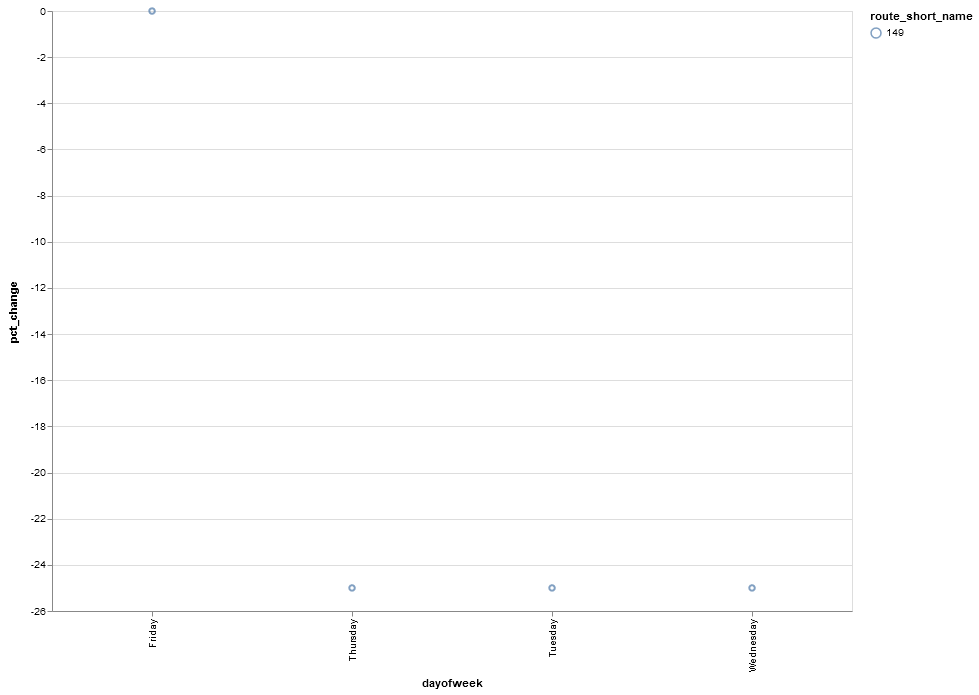

In [36]:
alt.Chart(comp_route[~comp_route.dayofweek.isin(('Saturday', 'Sunday', 'Monday'))]).mark_point().encode(
    x = alt.X('dayofweek:N', ),
    y = 'pct_change',
    color = 'route_short_name:N',
    tooltip = 'route_short_name',
).properties(height=600, width=800)

In [37]:
id_num_trips_agency = eid_routes.groupby(['dayofweek', 'agency_name']).num_trips.sum()
week_before_agency = week_before_routes.groupby(['dayofweek', 'agency_name']).num_trips.sum()

comp_agency = (pd.concat([week_before_agency, id_num_trips_agency], axis=1, keys = ['week_before', 'eid'])
             #.stack()
             .reset_index()
             #.rename(columns={'level_2': 'week', 0: 'num_trips'})
            )


comp_agency['pct_change'] = (-100*(1-np.round((comp_agency.eid/comp_agency.week_before), 2))).astype(int)

sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
comp_agency.dayofweek = comp_agency.dayofweek.astype("category")
comp_agency.dayofweek.cat.set_categories(sorter, inplace=True)
comp_agency=comp_agency.sort_values('dayofweek')
comp_agency

,dayofweek,agency_name,week_before,eid,pct_change
37,Monday,ירושלים-דרום איחוד,316,316,0
25,Monday,אגד,22360,22306,0
26,Monday,אגד תעבורה,3900,3900,0
27,Monday,אפיקים,7927,7855,-1
28,Monday,גי.בי.טורס,411,411,0
29,Monday,גלים,792,792,0
30,Monday,דן,9792,9328,-5
31,Monday,דן באר שבע,2945,2945,0
32,Monday,דן בדרום,4258,4258,0
33,Monday,דן צפון,960,961,0


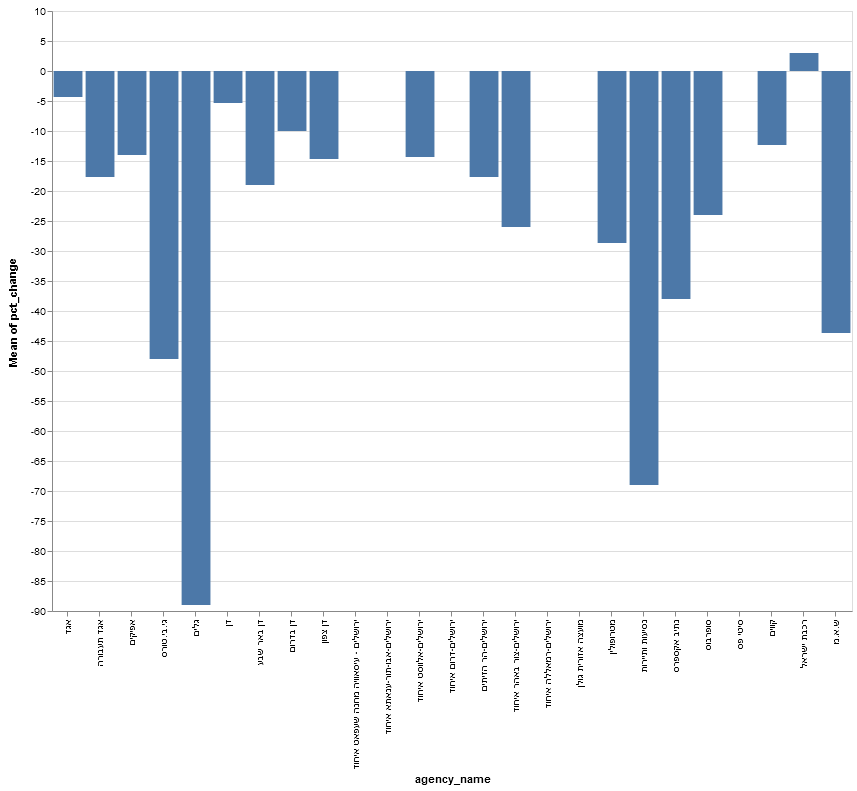

In [38]:
alt.Chart(comp_agency[~comp_agency.dayofweek.isin(('Saturday', 'Sunday', 'Monday', 'Friday'))]).mark_bar().encode(
    #color = 'dayofweek:N',
    y = 'mean(pct_change)',
    x = 'agency_name:N',
    tooltip = ['agency_name'],
).properties(height=600, width=800)